In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

In [ ]:
d1 = pd.read_csv("../data/raw/UTR5_sequence_counts_05_23_23.tsv", sep="\t", index_col=0, header=[0, 1, 2])
d1.index.name = "seq"
d1.columns.names = ["cell_type", "replicate", "bin"]
d1

In [3]:
fits = pd.read_csv("fit_results_utr5.csv")
fits.head()

,cell_type,replicate,bin,wd1,wd2,psi,p1,n1,p2,n2
0,c1,1,1,0.473089,0.526911,0.975089,0.001700,0.675225,0.005972,5.134402
1,c1,1,2,0.411395,0.588605,0.981577,0.003530,0.647302,0.008774,5.060857
2,c1,1,3,0.252498,0.747502,0.990757,0.028531,0.784640,0.003794,2.361286
3,c1,1,4,0.101299,0.898701,0.975073,0.174933,1.864739,0.002333,1.377099
4,c1,2,1,0.243283,0.756717,0.977683,0.006868,0.657015,0.005048,2.947024


The distribution should be the most 'typical' one.

Let's assume that the most 'typical' distribution is the one with the closest to average read count value.

In [4]:
ref_ct, ref_rep, ref_bin = d1.columns[np.abs(d1.mean(axis=0) - d1.mean(axis=None)).argmin()]
reference_fit_id = (ref_ct, int(ref_rep), int(ref_bin))
reference_fit_id

('c6', 2, 1)

In [5]:
reference_fit_params = fits.set_index(["cell_type", "replicate", "bin"]).loc[reference_fit_id].to_dict()
reference_fit_params

{'wd1': 0.3868212945819003,
 'wd2': 0.6131787054180997,
 'psi': 0.9836780567472014,
 'p1': 0.0011923047901109,
 'n1': 0.6326889174306066,
 'p2': 0.0029686888146403,
 'n2': 4.3267421105465225}

In [6]:
def get_reference_rv(wd1, wd2, psi, p1, n1, p2, n2):
    wd_est = np.array([wd1, wd2])
    mixture_dist = pm.Mixture.dist(
        w=wd_est,
        comp_dists=[
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi, p=p1, n=n1),
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi, p=p2, n=n2),
        ])
    return mixture_dist

In [7]:
reference_rv = get_reference_rv(**reference_fit_params)

Checking the maximal theoretical value (it's unlikely that we are going to exceed it)

In [8]:
max_theoretical_value = d1.max(axis=None)
max_theoretical_value

36881

In [9]:
def get_discrete_quantile_function(rv, min_value=0, max_value=100_000):
    if min_value != 0:
        raise NotImplementedError
    logcdf = pm.logcdf(rv, np.arange(0, max_value + 1)).eval()
    cdf = np.exp(logcdf)

    def quantile(q: np.array):
        q = np.asarray(q)
        values = np.abs(cdf - q[:, None]).argmin(axis=1)
        return values

    return quantile

In [10]:
d1_normalized = d1.copy()

for (cell_type_id, replicate_id), fits_grp in tqdm(fits.groupby(by=["cell_type", "replicate"])):
    for i, lib_fit in fits_grp.iterrows():
        # Fitting library
        lib_key = (lib_fit["cell_type"], str(lib_fit["replicate"]), str(lib_fit["bin"]))
        lib = d1[lib_key].values
        libmax = lib.max()
        lib_fit_params = lib_fit.iloc[3:].to_dict()

        # Calculating CDF
        lib_rv = get_reference_rv(**lib_fit_params)
        lib_logcdf = logcdf = pm.logcdf(lib_rv, np.arange(0, libmax + 1)).eval()
        lib_cdf = np.exp(lib_logcdf)
        lib_q = lib_cdf[lib]  # Since library starts at 0, cdf array is the inverse quantile function

        # Calculating quantiles
        reference_q_func = get_discrete_quantile_function(reference_rv, max_value=max_theoretical_value)
        lib_norm = reference_q_func(lib_q)

        # Normalizing CPMs
        # # Notice the pseudocount
        lib_norm_cpm = (lib_norm + 1) / lib_norm.sum() * 1_000_000
        d1_normalized[lib_key] = lib_norm_cpm

  0%|          | 0/10 [00:00<?, ?it/s]

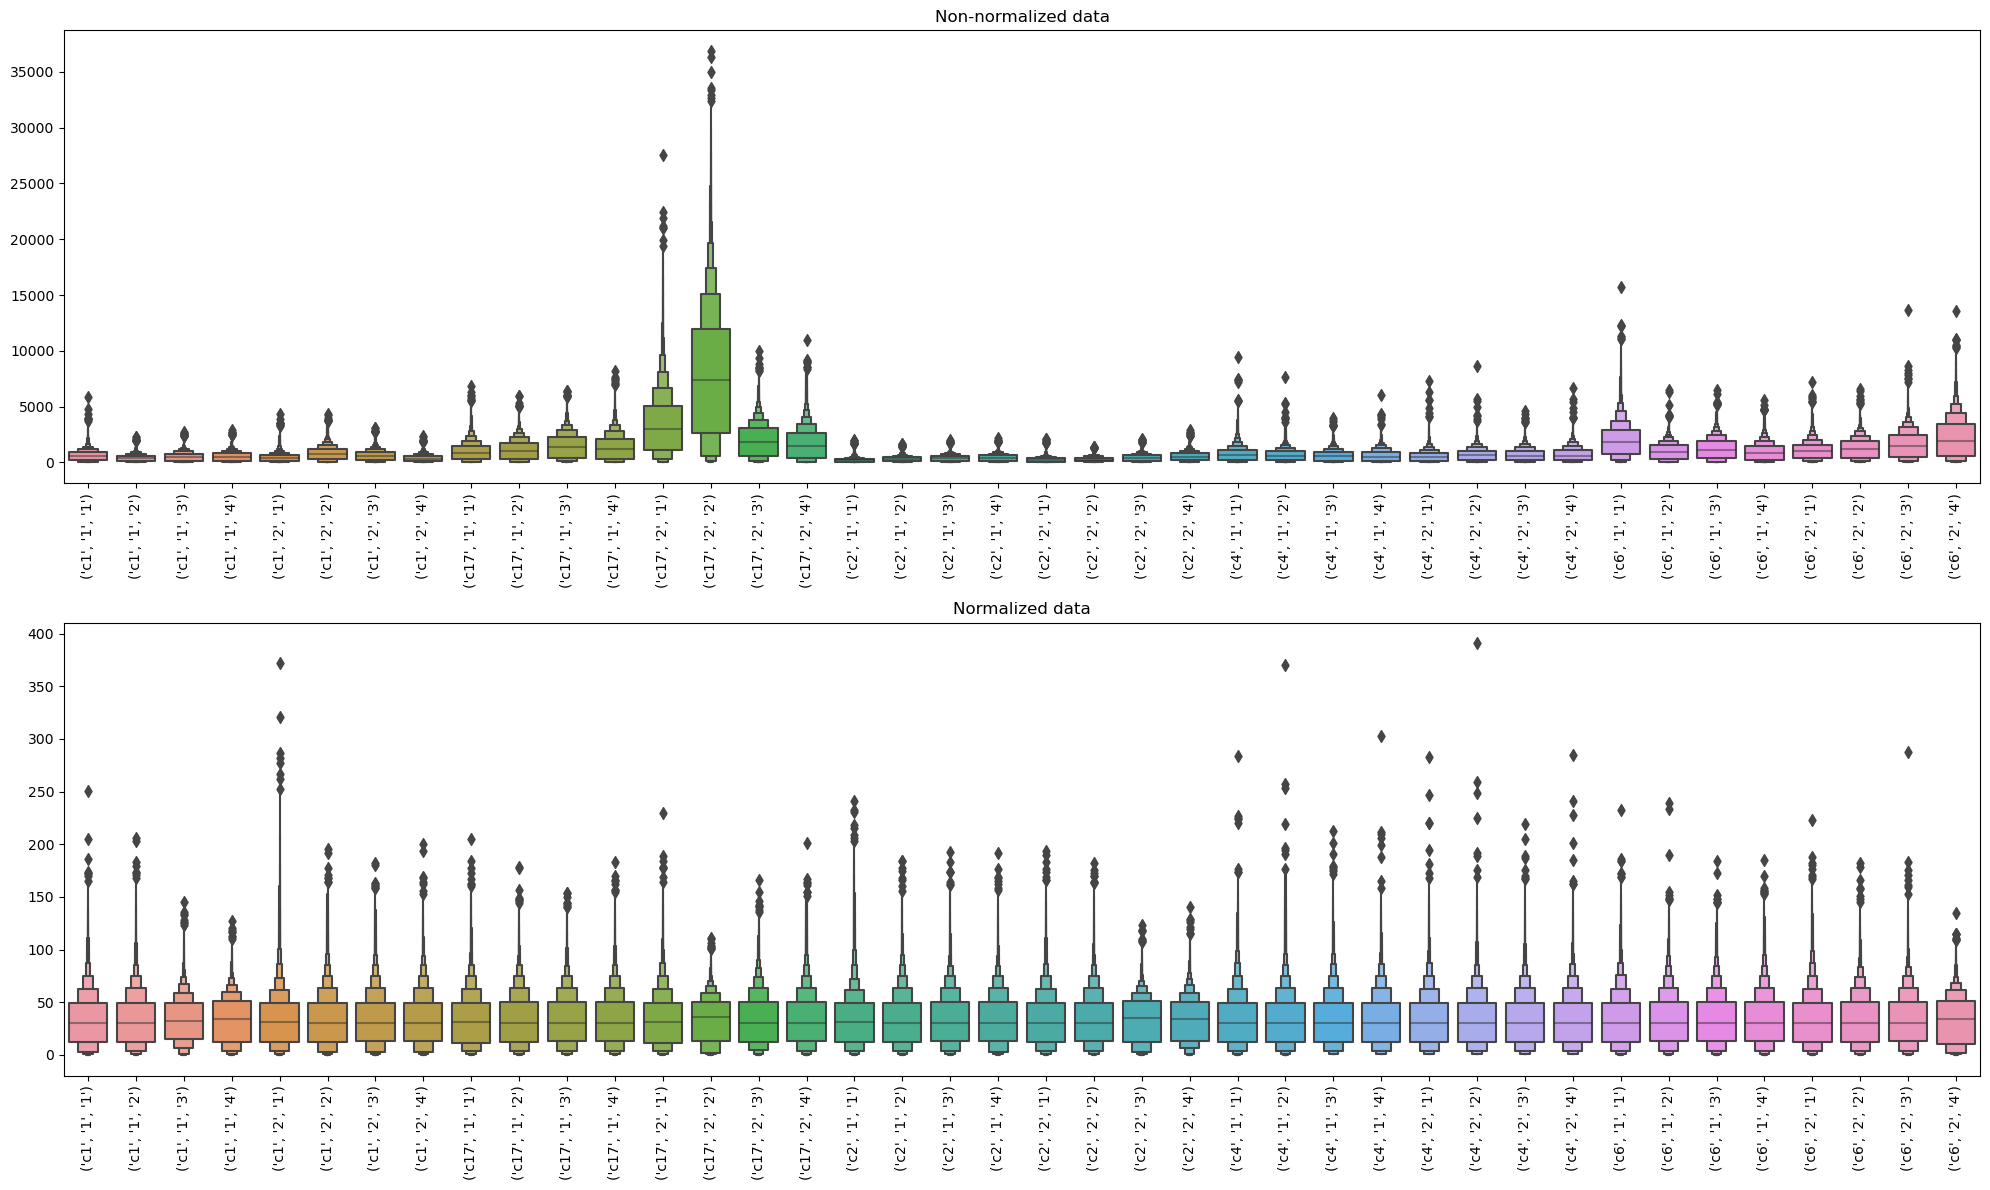

In [11]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
sns.boxenplot(d1)
plt.xticks(rotation=90)
plt.title("Non-normalized data")

plt.subplot(2, 1, 2)
sns.boxenplot(d1_normalized)
plt.xticks(rotation=90)
plt.title("Normalized data")

plt.tight_layout()
plt.show()

## Preprocessing

In [12]:
filtering_df = pd.read_csv("../data/raw/UTR5_filtered_normalized_05_23_23.tsv", sep="\t", index_col=0, header=[0, 1, 2])
filtered_seqs = filtering_df.index

In [ ]:
d1_filtered = d1_normalized.loc[filtered_seqs]
d1_filtered.index.name = "seq"
d1_filtered

In [14]:
##################################
#      TRAIN-VAL-TEST SPLIT      #
##################################
# DO NOT CHANGE UNLESS NECESSARY #
##################################
np.random.seed(777)
mark = np.full(fill_value="train", shape=(d1_filtered.shape[0],))
mark[0:mark.shape[0] // 10] = "test"
mark[mark.shape[0] // 10:2 * mark.shape[0] // 10] = "val"
np.random.shuffle(mark)
mark = pd.Series(mark)
mark.index = d1_filtered.index
mark.value_counts()

train    17288
val       2161
test      2160
Name: count, dtype: int64

In [ ]:
d1_stacked = d1_filtered.stack(level=[0], dropna=False).reset_index()
d1_stacked.columns.name = None
d1_stacked

In [17]:
d1_stacked = d1_stacked.set_index(["seq", "cell_type"]).stack(level=0).reset_index()

In [ ]:
d1_split = d1_stacked.set_index("seq")
d1_split["fold"] = mark
d1_split

In [19]:
d1_split.to_csv("../data/UTR5_zinb_norm_singleref_2023-05-23.csv")